<a href="https://colab.research.google.com/github/ghosucipto62-afk/Analytical-Project/blob/main/SARIMA_volume_kg_GARCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from typing import Union
from tqdm.notebook import tqdm
import warnings

warnings.filterwarnings("ignore")

In [2]:
# ============================
# 1) Import library & load data
# ============================
df = pd.read_csv("pembelian.csv", parse_dates=["tanggal_pembelian"])

# Cek data awal
print("Data awal (5 baris pertama):")
print(df.head())
print("\nInformasi DataFrame:")
print(df.info())


Data awal (5 baris pertama):
   id_pembelian tanggal_pembelian  id_greenbean  id_supplier  volume_kg  \
0             5        2022-05-01             3            9       30.0   
1             6        2022-05-01             8            9       30.0   
2             7        2022-05-12             9            7        7.2   
3             8        2022-05-10             4            7        5.0   
4             9        2022-05-12             4           10      100.0   

   harga_per_kg  ongkos_kirim  jumlah_total jenis_transaksi  \
0       90000.0       30000.0     2730000.0           tunai   
1       38000.0           0.0     1140000.0           tunai   
2       45000.0           0.0      324000.0           tunai   
3       95000.0           0.0      475000.0           tunai   
4       90000.0           0.0     9000000.0           tunai   

   tanggal_pelunasan           created_at           updated_at  
0                NaN  2025-08-22 13:08:40  2025-08-22 13:08:40  
1          

In [35]:
# ============================
# 1) Import library & load data
# ============================
import pandas as pd

df = pd.read_csv("pembelian.csv", parse_dates=["tanggal_pembelian"])

# Cek data awal
print("Data awal (5 baris pertama):")
print(df.head())
print("\nInformasi DataFrame:")
print(df.info())

Data awal (5 baris pertama):
   id_pembelian tanggal_pembelian  id_greenbean  id_supplier  volume_kg  \
0             5        2022-05-01             3            9       30.0   
1             6        2022-05-01             8            9       30.0   
2             7        2022-05-12             9            7        7.2   
3             8        2022-05-10             4            7        5.0   
4             9        2022-05-12             4           10      100.0   

   harga_per_kg  ongkos_kirim  jumlah_total jenis_transaksi  \
0       90000.0       30000.0     2730000.0           tunai   
1       38000.0           0.0     1140000.0           tunai   
2       45000.0           0.0      324000.0           tunai   
3       95000.0           0.0      475000.0           tunai   
4       90000.0           0.0     9000000.0           tunai   

   tanggal_pelunasan           created_at           updated_at  
0                NaN  2025-08-22 13:08:40  2025-08-22 13:08:40  
1          

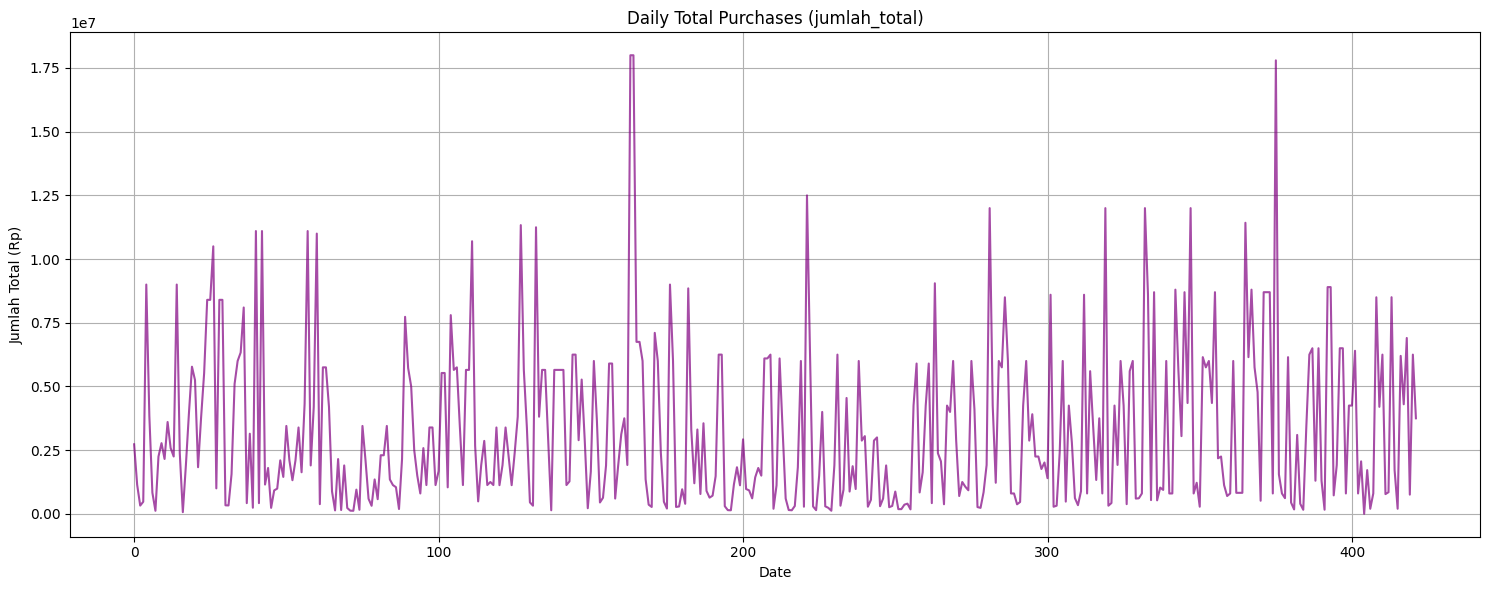

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(df.index, df['jumlah_total'], color='purple', alpha=0.7)
plt.title('Daily Total Purchases (jumlah_total)')
plt.xlabel('Date')
plt.ylabel('Jumlah Total (Rp)')
plt.grid(True)
plt.tight_layout()
plt.show()

### Impact of Refined GARCH Volatility on Prediction Intervals

*   **Constant Volatility**: The GARCH model forecast for the next 12 months (aligned with the SARIMA forecast period) resulted in a constant volatility of approximately 234.444. This means the model converged to its long-run conditional standard deviation quickly.
*   **Consistent Prediction Intervals**: Due to this constant volatility, the width of the prediction intervals (Upper Bound - Lower Bound) remains consistent throughout the forecast period. For example, for 2025-08-01, a SARIMA forecast of 692.69 with a GARCH volatility of 234.44 resulted in a prediction interval from 233.18 to 1152.19.
*   **Implications**: The constant volatility suggests that while the GARCH model appears to remove ARCH effects from the residuals and passes diagnostic tests, it might not be capturing dynamic changes in volatility over the forecast horizon. This could indicate that the underlying series does not exhibit strong, predictable volatility clustering or that a simpler model might suffice. However, the prediction intervals still provide a valuable measure of uncertainty around the SARIMA point forecasts.

In [3]:
# ============================
# 2) Agregasi bulanan
# ============================
# Setting tanggal_pembelian sebagai index untuk resample
df = df.set_index("tanggal_pembelian")

# Agregasi data harian ke bulanan
# Menggunakan 'MS' (Month Start) agar data konsisten
df_monthly = df.resample("MS").sum(numeric_only=True)


In [4]:
# Ganti 0 dengan NaN agar bisa diisi median
df_monthly[['volume_kg','jumlah_total']] = df_monthly[['volume_kg','jumlah_total']].replace(0, np.nan)

# Isi NaN (termasuk yang sebelumnya 0) dengan median
df_monthly = df_monthly.fillna(df_monthly.median(numeric_only=True))

print(df_monthly.head())

                   id_pembelian  id_greenbean  id_supplier  volume_kg  \
tanggal_pembelian                                                       
2022-03-01                   13            10            4     30.000   
2022-04-01                    0             0            0    316.975   
2022-05-01                   57            45           57    273.200   
2022-06-01                   91            38           52    185.000   
2022-07-01                   82            31           37    175.550   

                   harga_per_kg  ongkos_kirim  jumlah_total  tanggal_pelunasan  
tanggal_pembelian                                                               
2022-03-01              75000.0           0.0     2250000.0                0.0  
2022-04-01                  0.0           0.0    31798815.0                0.0  
2022-05-01             511000.0      580000.0    17639000.0                0.0  
2022-06-01             460500.0      140000.0    14195000.0                0.0  
20

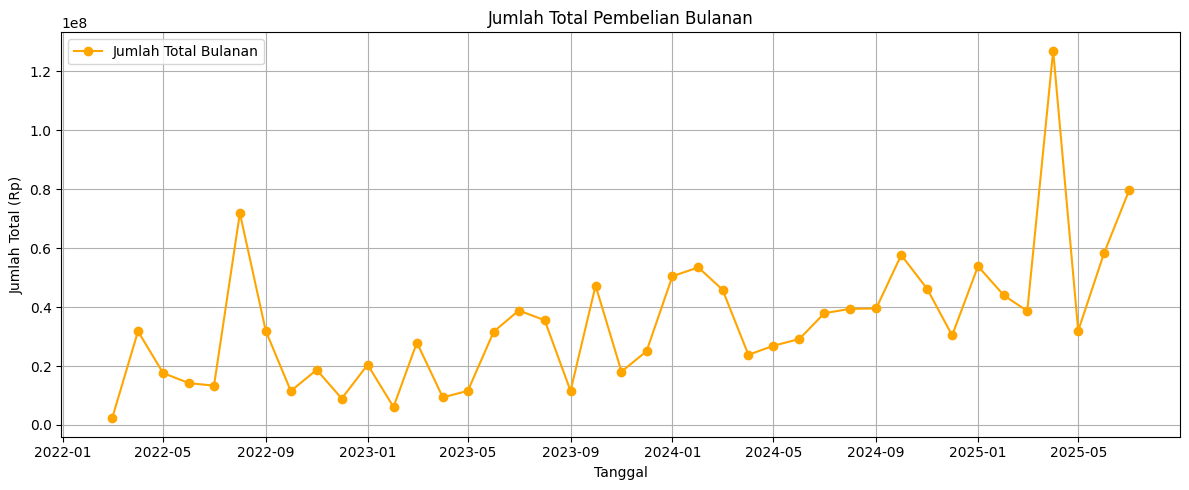

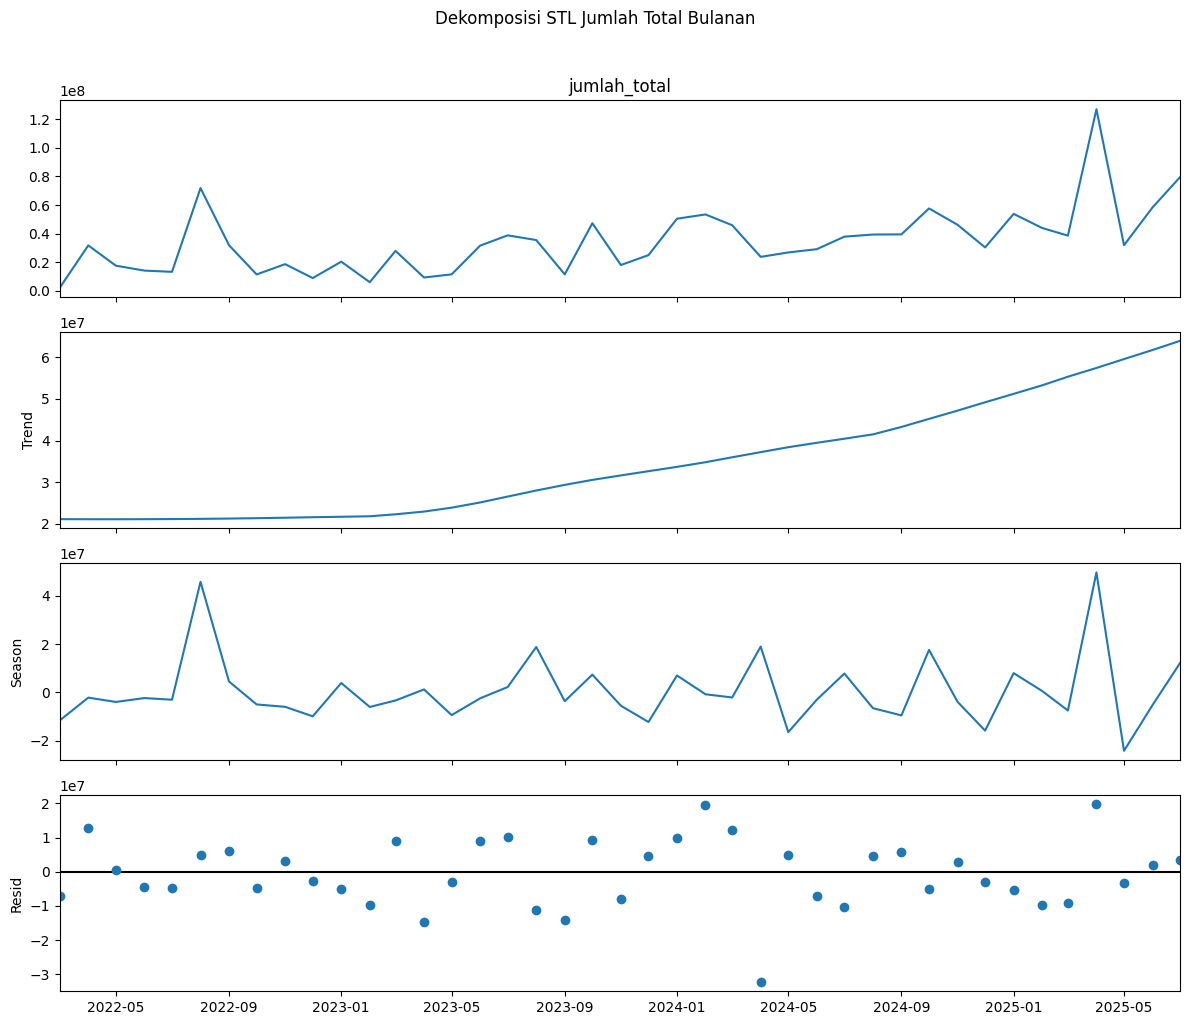

In [5]:
# ============================
# 3) Visualisasi Data dan STL
# ============================
plt.figure(figsize=(12,5))
plt.plot(df_monthly.index, df_monthly["jumlah_total"], marker='o', color='orange', label="Jumlah Total Bulanan")
plt.ylabel("Jumlah Total (Rp)")
plt.xlabel("Tanggal")
plt.title("Jumlah Total Pembelian Bulanan")
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()

# Dekomposisi STL
decomposition = STL(df_monthly['jumlah_total'], period=12).fit()
fig = decomposition.plot()
fig.set_size_inches(12, 10)
plt.suptitle("Dekomposisi STL Jumlah Total Bulanan", y=1.02)
plt.tight_layout()
plt.show()

In [6]:
# ============================
# 4) Uji Stasioneritas (ADF Test)
# ============================
print("\n=== Uji Stasioneritas (ADF Test) ===")

def adf_test(series, title=''):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f"Hasil ADF Test untuk {title}:")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    if result[1] <= 0.05:
        print("Data stasioner (p-value <= 0.05).")
    else:
        print("Data tidak stasioner (p-value > 0.05).")

# Uji pada data asli
adf_test(df_monthly['volume_kg'], 'Data Bulanan Asli')

# Differencing pertama (non-seasonal)
df_diff = df_monthly['volume_kg'].diff(1)
adf_test(df_diff, 'Differencing Pertama')

# Differencing musiman (seasonal)
df_diff_seasonal = df_monthly['volume_kg'].diff(12).dropna()
adf_test(df_diff_seasonal, 'Differencing Musiman (period 12)')

# Differencing gabungan
df_diff_both = df_diff.diff(12).dropna()
adf_test(df_diff_both, 'Differencing Pertama & Musiman')



=== Uji Stasioneritas (ADF Test) ===
Hasil ADF Test untuk Data Bulanan Asli:
ADF Statistic: -2.0143
p-value: 0.2803
Data tidak stasioner (p-value > 0.05).
Hasil ADF Test untuk Differencing Pertama:
ADF Statistic: -4.6561
p-value: 0.0001
Data stasioner (p-value <= 0.05).
Hasil ADF Test untuk Differencing Musiman (period 12):
ADF Statistic: -4.8904
p-value: 0.0000
Data stasioner (p-value <= 0.05).
Hasil ADF Test untuk Differencing Pertama & Musiman:
ADF Statistic: -4.5831
p-value: 0.0001
Data stasioner (p-value <= 0.05).


In [7]:
# ============================
# 5) Optimalisasi Model SARIMA
# ============================

def optimize_SARIMA(endog: Union[pd.Series, list], p_range: range, q_range: range, P_range: range, Q_range: range, d: int, D: int, s: int) -> pd.DataFrame:
    results = []

    # Perbaikan: 'd' dan 'D' dimasukkan dalam list [] agar bisa diiterasi
    order_list = list(itertools.product(p_range, [d], q_range))
    seasonal_order_list = list(itertools.product(P_range, [D], Q_range, [s]))

    # Membuat semua kombinasi SARIMA order
    full_order_list = list(itertools.product(order_list, seasonal_order_list))

    print(f"\nMencoba {len(full_order_list)} kombinasi SARIMA...")

    for orders in tqdm(full_order_list, desc="Optimizing SARIMA"):
        try:
            model = SARIMAX(
                endog,
                order=(orders[0][0], orders[0][1], orders[0][2]),
                seasonal_order=(orders[1][0], orders[1][1], orders[1][2], orders[1][3]),
                enforce_stationarity=False,
                enforce_invertibility=False,
                simple_differencing=False
            ).fit(disp=False)
            results.append([
                (orders[0][0], orders[0][1], orders[0][2]),
                (orders[1][0], orders[1][1], orders[1][2], orders[1][3]),
                model.aic
            ])
        except Exception as e:
            continue

    result_df = pd.DataFrame(results, columns=['(p,d,q)', '(P,D,Q,s)', 'AIC'])
    return result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)



In [8]:
# Ambil data training (semua kecuali 12 bulan terakhir)
train = df_monthly['volume_kg'][:-12]
test = df_monthly['volume_kg'][-12:].copy()

# Parameter differencing dari hasil uji ADF
d = 1
D = 1
s = 12

# Range untuk p, q, P, Q yang lebih optimal
p = range(0, 3)
q = range(0, 3)
P = range(0, 2)
Q = range(0, 2)

# Optimalisasi SARIMA
SARIMA_result_df = optimize_SARIMA(train, p, q, P, Q, d=d, D=D, s=s)

print("\n10 Model SARIMA Terbaik:")
print(SARIMA_result_df.head(10))



Mencoba 36 kombinasi SARIMA...


Optimizing SARIMA:   0%|          | 0/36 [00:00<?, ?it/s]


10 Model SARIMA Terbaik:
     (p,d,q)      (P,D,Q,s)        AIC
0  (0, 1, 2)  (1, 1, 1, 12)   3.165678
1  (0, 1, 2)  (0, 1, 1, 12)   3.671027
2  (1, 1, 1)  (1, 1, 1, 12)   3.970927
3  (1, 1, 2)  (0, 1, 1, 12)   8.431843
4  (2, 1, 2)  (0, 1, 1, 12)  10.166135
5  (1, 1, 2)  (1, 1, 1, 12)  13.615402
6  (2, 1, 1)  (1, 1, 1, 12)  15.766551
7  (2, 1, 1)  (1, 1, 0, 12)  22.407246
8  (2, 1, 2)  (1, 1, 1, 12)  24.714235
9  (2, 1, 1)  (0, 1, 1, 12)  26.218669


In [9]:
# ============================
# 6) Pemodelan, Diagnostik, dan Prediksi
# ============================
# Pilih model terbaik berdasarkan AIC
best_order = SARIMA_result_df.iloc[0]['(p,d,q)']
best_seasonal_order = SARIMA_result_df.iloc[0]['(P,D,Q,s)']

print(f"\nMemilih model terbaik: SARIMA{best_order}x{best_seasonal_order}")

# Fit model terbaik
best_SARIMA_model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order, simple_differencing=False)
best_SARIMA_model_fit = best_SARIMA_model.fit(disp=False)


Memilih model terbaik: SARIMA(0, 1, 2)x(1, 1, 1, 12)



Plot Diagnostik Model SARIMA:


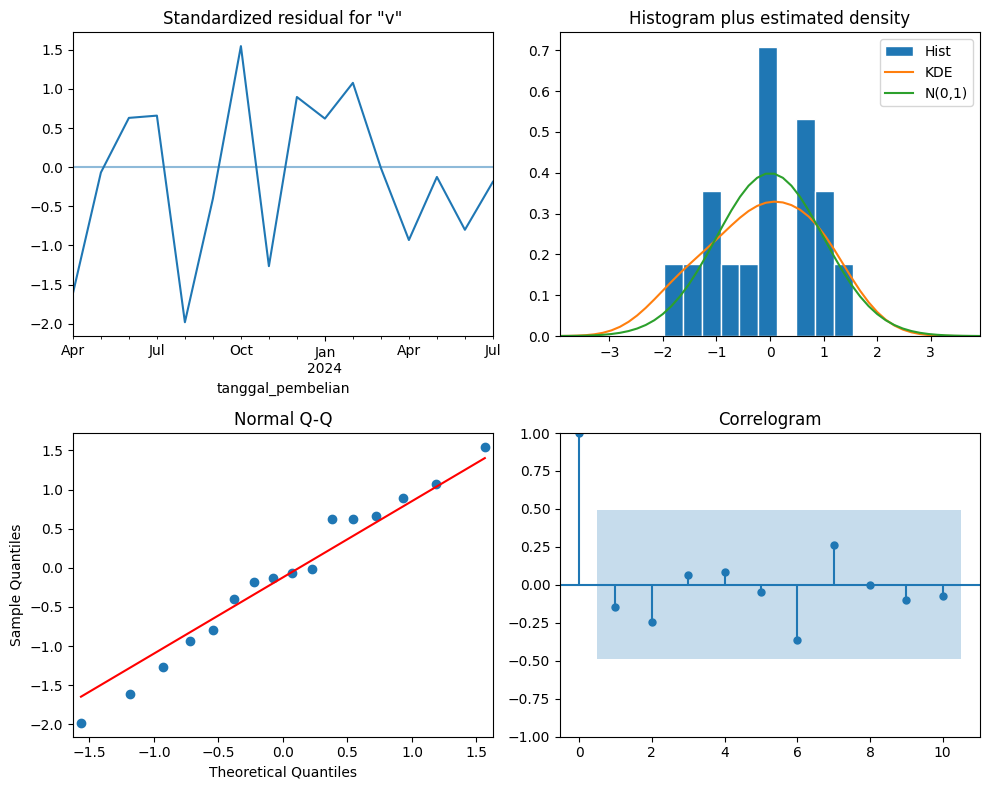

In [10]:
# Diagnostik model
print("\nPlot Diagnostik Model SARIMA:")
best_SARIMA_model_fit.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show()


In [11]:
# Uji Ljung-Box
print("\nUji Ljung-Box untuk Residual:")
residual = best_SARIMA_model_fit.resid
lb_test = acorr_ljungbox(residual, lags=np.arange(1, 11, 1), return_df=True)
print(lb_test[['lb_stat', 'lb_pvalue']])



Uji Ljung-Box untuk Residual:
      lb_stat  lb_pvalue
1    1.524021   0.217012
2    3.902148   0.142121
3    3.937441   0.268299
4    5.531813   0.236947
5    6.080458   0.298469
6    8.152874   0.227116
7   12.473669   0.086019
8   14.937125   0.060380
9   15.140976   0.087136
10  15.223498   0.124124


In [12]:
# Prediksi untuk 12 bulan ke depan
forecast_object = best_SARIMA_model_fit.get_forecast(steps=12)
SARIMA_pred = forecast_object.predicted_mean
test['SARIMA_pred'] = SARIMA_pred

In [13]:
# Buat prediksi Naive Seasonal untuk perbandingan
test['naive_seasonal'] = df_monthly['volume_kg'].shift(12).iloc[-12:].values



MAPE Naive Seasonal: 39.06%
MAPE SARIMA: 29.69%


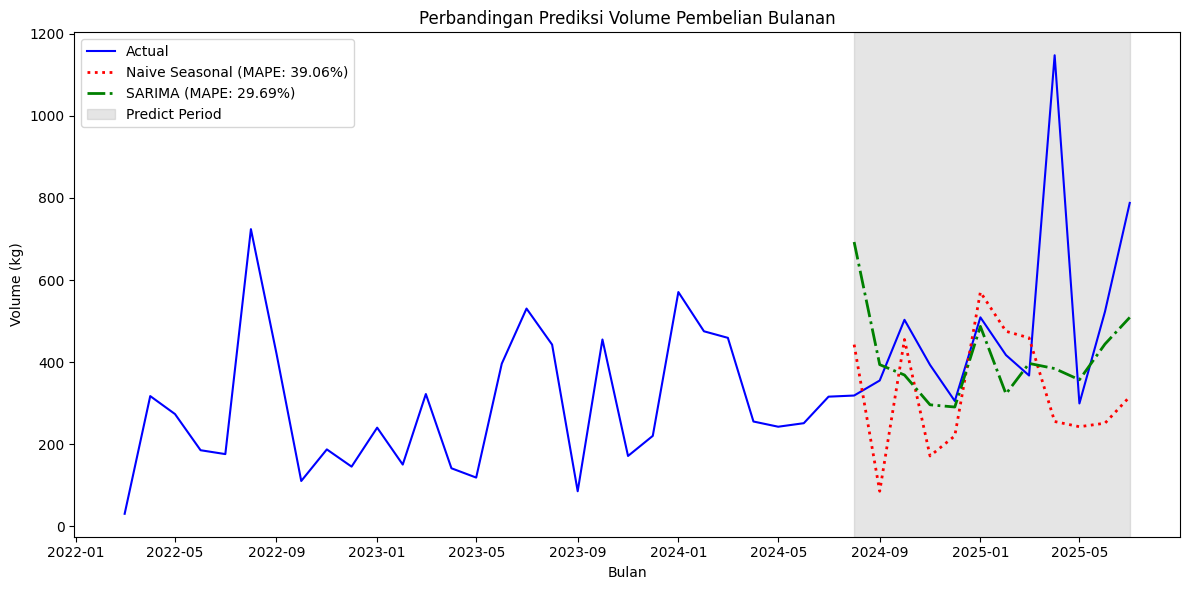

In [14]:
# ============================
# 7) Evaluasi Model (MAPE) dan Visualisasi Akhir
# ============================

import numpy as np
import matplotlib.pyplot as plt

# Fungsi MAPE
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    return np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100

# ----------------------------
# Pastikan test adalah DataFrame
# ----------------------------
test = df_monthly[-12:].copy()   # ambil 12 bulan terakhir
test = test[['volume_kg']].copy()  # hanya kolom volume_kg
test = test.reset_index()          # jadikan tanggal sebagai kolom
test.set_index('tanggal_pembelian', inplace=True)  # index = datetime

# ----------------------------
# Tambahkan prediksi
# ----------------------------
# Prediksi SARIMA
SARIMA_pred = best_SARIMA_model_fit.get_forecast(steps=len(test)).predicted_mean
test['SARIMA_pred'] = SARIMA_pred.values

# Prediksi Naive Seasonal (shift 12 bulan)
test['naive_seasonal'] = df_monthly['volume_kg'].shift(12).iloc[-12:].values

# ----------------------------
# Ambil data aktual sesuai indeks test
# ----------------------------
test_actual = df_monthly['volume_kg'].reindex(test.index)

# ----------------------------
# Hitung MAPE
# ----------------------------
mape_naive = mape(test_actual, test['naive_seasonal'])
mape_SARIMA = mape(test_actual, test['SARIMA_pred'])

print(f"\nMAPE Naive Seasonal: {mape_naive:.2f}%")
print(f"MAPE SARIMA: {mape_SARIMA:.2f}%")

# ----------------------------
# Visualisasi
# ----------------------------
fig, ax = plt.subplots(figsize=(12, 6))

# Data aktual
ax.plot(df_monthly.index, df_monthly['volume_kg'], 'b-', label='Actual')

# Prediksi
ax.plot(test.index, test['naive_seasonal'], 'r:', label=f'Naive Seasonal (MAPE: {mape_naive:.2f}%)', linewidth=2)
ax.plot(test.index, test['SARIMA_pred'], 'g-.', label=f'SARIMA (MAPE: {mape_SARIMA:.2f}%)', linewidth=2)

ax.set_xlabel('Bulan')
ax.set_ylabel('Volume (kg)')
ax.axvspan(test.index[0], test.index[-1], color='#808080', alpha=0.2, label='Predict Period')
ax.legend(loc='upper left')

plt.title("Perbandingan Prediksi Volume Pembelian Bulanan")
plt.tight_layout()
plt.show()


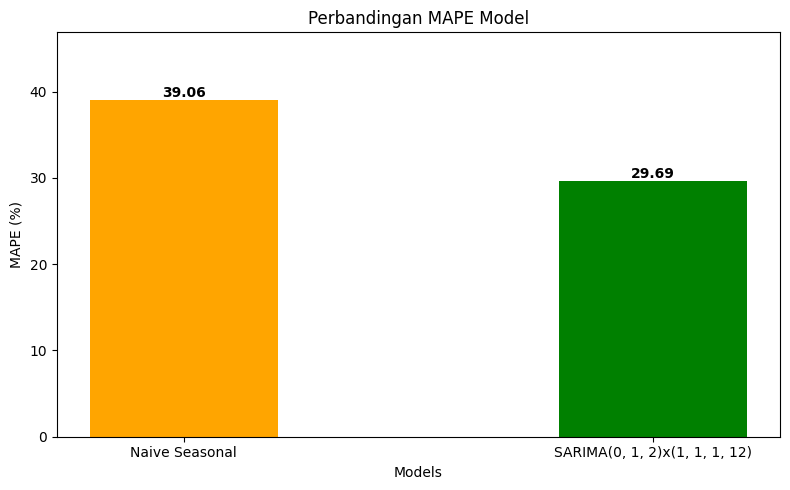

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------
# Fungsi MAPE
# ----------------------------
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    return np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100

# ----------------------------
# Hitung MAPE
# ----------------------------
mape_naive_seasonal = mape(test['volume_kg'], test['naive_seasonal'])
mape_SARIMA = mape(test['volume_kg'], test['SARIMA_pred'])

# ----------------------------
# Bar plot perbandingan MAPE
# ----------------------------
models = ['Naive Seasonal', f'SARIMA{best_order}x{best_seasonal_order}']
values = [mape_naive_seasonal, mape_SARIMA]

fig, ax = plt.subplots(figsize=(8,5))
ax.bar(models, values, width=0.4, color=['orange','green'])
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, max(values)*1.2)  # beri ruang di atas untuk label
ax.set_title("Perbandingan MAPE Model")

# Tambahkan label nilai di atas bar
for i, v in enumerate(values):
    ax.text(i, v + 0.3, str(round(v,2)), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


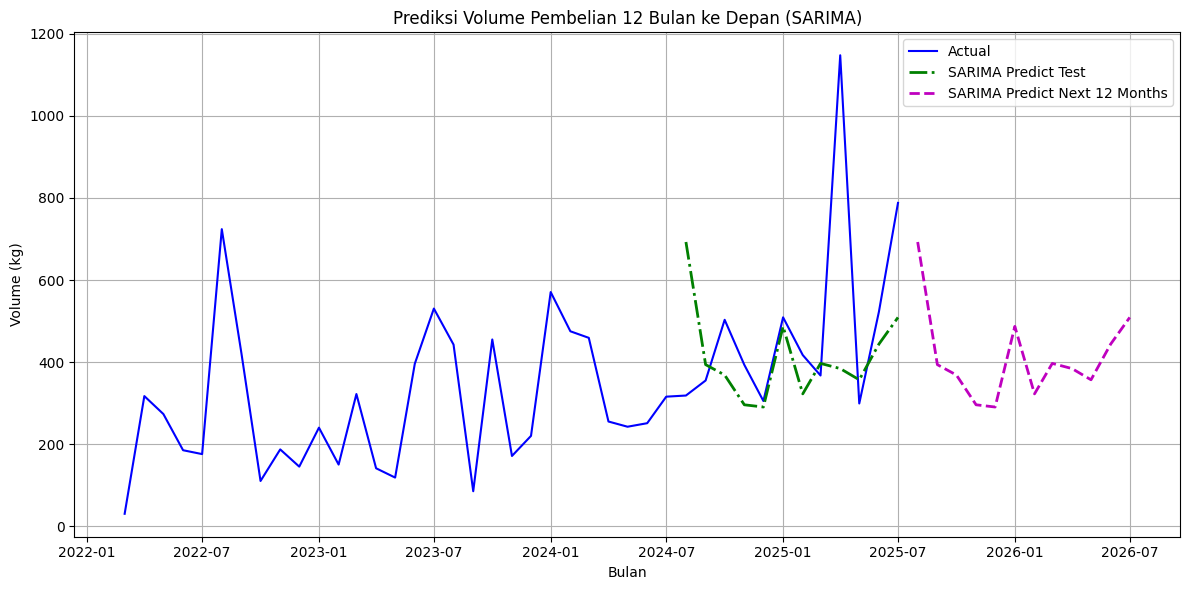


Prediksi 12 Bulan ke Depan:
      tanggal  SARIMA_forecast
0  2025-08-01       692.686750
1  2025-09-01       393.688291
2  2025-10-01       368.373169
3  2025-11-01       295.752587
4  2025-12-01       290.340465
5  2026-01-01       486.922144
6  2026-02-01       322.383006
7  2026-03-01       396.683819
8  2026-04-01       384.094032
9  2026-05-01       356.729822
10 2026-06-01       443.866671
11 2026-07-01       508.827589


In [16]:
# =============================
# 8) 12 Bulan ke Depan
# =============================

# Forecast 12 bulan berikutnya dari akhir data bulanan
future_forecast = best_SARIMA_model_fit.get_forecast(steps=12)
future_index = pd.date_range(start=df_monthly.index[-1] + pd.offsets.MonthBegin(1), periods=12, freq='MS')
future_pred = pd.Series(future_forecast.predicted_mean.values, index=future_index)

# Visualisasi proyeksi
fig, ax = plt.subplots(figsize=(12,6))

# Data historis
ax.plot(df_monthly.index, df_monthly['volume_kg'], 'b-', label='Actual')

# Forecast 12 bulan terakhir (uji)
ax.plot(test.index, test['SARIMA_pred'], 'g-.', label='SARIMA Predict Test', linewidth=2)

# Forecast 12 bulan ke depan
ax.plot(future_index, future_pred, 'm--', label='SARIMA Predict Next 12 Months', linewidth=2)

ax.set_xlabel('Bulan')
ax.set_ylabel('Volume (kg)')
ax.set_title("Prediksi Volume Pembelian 12 Bulan ke Depan (SARIMA)")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

# Cetak hasil proyeksi
forecast_df = pd.DataFrame({
    'tanggal': future_index,
    'SARIMA_forecast': future_pred.values
})
print("\nPrediksi 12 Bulan ke Depan:")
print(forecast_df)


# Task
Fit a GARCH model to the residuals (`residual`) obtained from the best SARIMA model and forecast the volatility.

## Extract SARIMA Residuals

### Subtask:
Obtain the residuals from the fitted SARIMA model (best_SARIMA_model_fit.resid) to analyze their volatility.


**Reasoning**:
I need to extract the residuals from the fitted SARIMA model and store them in a pandas Series with the correct time series index, then display the head of the series to confirm the extraction.



In [17]:
sarima_residuals = best_SARIMA_model_fit.resid
print("SARIMA Residuals (first 5 values):")
print(sarima_residuals.head())

SARIMA Residuals (first 5 values):
tanggal_pembelian
2022-03-01     30.000000
2022-04-01    287.086635
2022-05-01    -41.199707
2022-06-01    -79.535688
2022-07-01    -11.325948
Freq: MS, dtype: float64


## Fit GARCH Model to Residuals

### Subtask:
Fit an ARCH or GARCH model to the squared residuals of the SARIMA model. This step will capture the conditional heteroskedasticity (volatility clustering) in the data.


**Reasoning**:
I need to import the `arch_model` class, define a GARCH(1,1) model with a constant mean using the SARIMA residuals, fit the model, and then display its summary to fulfill the subtask instructions.



In [ ]:
get_ipython().system('pip install arch')

from arch import arch_model

# Create and fit the GARCH(1,1) model
# Using 'Constant' for mean model as residuals are expected to have zero mean.
# 'o' indicates the order for the ARCH term, 'q' for the GARCH term.
garch_model = arch_model(sarima_residuals, mean='Constant', vol='GARCH', p=1, q=1)
garch_result = garch_model.fit(disp='off')

# Print the summary of the GARCH model
print("\nGARCH(1,1) Model Summary:")
print(garch_result.summary())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 37.4 MB/s eta 0:00:00

GARCH(1,1) Model Summary:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -199.163
Distribution:                  Normal   AIC:                           406.327
Method:            Maximum Likelihood   BIC:                           411.796
                                        No. Observations:                   29
Date:                Wed, Dec 24 2025   Df Residuals:                       28
Time:                        08:51:18   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
-----------------------------------

In [20]:
from arch import arch_model

# Create and fit the GARCH(1,1) model
# Using 'Constant' for mean model as residuals are expected to have zero mean.
# 'o' indicates the order for the ARCH term, 'q' for the GARCH term.
garch_model = arch_model(sarima_residuals, mean='Constant', vol='GARCH', p=1, q=1)
garch_result = garch_model.fit(disp='off')

# Print the summary of the GARCH model
print("\nGARCH(1,1) Model Summary:")
print(garch_result.summary())


GARCH(1,1) Model Summary:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -199.163
Distribution:                  Normal   AIC:                           406.327
Method:            Maximum Likelihood   BIC:                           411.796
                                        No. Observations:                   29
Date:                Wed, Dec 24 2025   Df Residuals:                       28
Time:                        08:51:25   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -5.4653     43.950     -0.124

**Reasoning**:
The previous cell failed because the `arch` module was not found. I need to install it using `!pip install` before trying to import and use it.



## Forecast GARCH Volatility

### Subtask:
Generate future volatility forecasts using the fitted GARCH model.


**Reasoning**:
I need to generate future volatility forecasts using the fitted GARCH model. I will use the `forecast` method, extract the conditional volatility, and create a pandas Series with appropriate dates.



In [21]:
import pandas as pd

# Generate future volatility forecasts using the fitted GARCH model
# The 'start' parameter should be the index from which to begin forecasting.
# Since we want to forecast after the last residual, we use the last index of sarima_residuals.
forecast_garch = garch_result.forecast(horizon=12, start=sarima_residuals.index[-1])

# Extract the conditional volatility (standard deviation) from the forecast results
# The forecast object returns variance, so we take the square root to get standard deviation.
# We are interested in the 1-step ahead forecast, which is typically 'h.1'
forecast_volatility = np.sqrt(forecast_garch.variance.iloc[-1])

# Create a pandas Series for the forecasted volatility
# The index should be for the next 12 months, starting from the month after the last sarima_residuals index.
last_residual_date = sarima_residuals.index[-1]
future_volatility_index = pd.date_range(start=last_residual_date + pd.offsets.MonthBegin(1), periods=12, freq='MS')

# Ensure the forecast_volatility has the same length as future_volatility_index
# The forecast_garch.variance.iloc[-1] already gives a Series of 12 horizons
forecasted_garch_volatility = pd.Series(forecast_volatility.values, index=future_volatility_index, name='GARCH Volatility Forecast')

# Print the forecasted volatility Series
print("\nForecasted GARCH Volatility for next 12 months:")
print(forecasted_garch_volatility)


Forecasted GARCH Volatility for next 12 months:
2024-08-01    234.444085
2024-09-01    234.444085
2024-10-01    234.444085
2024-11-01    234.444085
2024-12-01    234.444085
2025-01-01    234.444085
2025-02-01    234.444085
2025-03-01    234.444085
2025-04-01    234.444085
2025-05-01    234.444085
2025-06-01    234.444085
2025-07-01    234.444085
Freq: MS, Name: GARCH Volatility Forecast, dtype: float64


## Combine SARIMA and GARCH Forecasts

### Subtask:
Integrate the SARIMA point forecasts with the GARCH volatility forecasts to create prediction intervals, providing a hybrid forecast that accounts for both the expected value and the expected volatility of future observations.


**Reasoning**:
I need to define a confidence level and its corresponding Z-score, then combine the SARIMA point forecasts and GARCH volatility forecasts into a new DataFrame. Finally, I will calculate the upper and lower prediction intervals based on these values.



In [22]:
import scipy.stats as st

# 1. Define a confidence level for the prediction intervals (e.g., 95%) and calculate the corresponding Z-score.
confidence_level = 0.95
z_score = st.norm.ppf(1 - (1 - confidence_level) / 2)
print(f"Confidence Level: {confidence_level*100}%")
print(f"Corresponding Z-score: {z_score:.2f}")

# 2. Create a DataFrame named hybrid_forecast_df that combines the SARIMA_pred (point forecasts) and forecasted_garch_volatility (volatility forecasts).
# Ensure both series have the same index for accurate combination
# SARIMA_pred is from forecast_df['SARIMA_forecast'] (future_pred in X6FXDgO5Bd2w)
# forecasted_garch_volatility is from the previous step

hybrid_forecast_df = pd.DataFrame({
    'SARIMA_forecast': future_pred,
    'GARCH_volatility': forecasted_garch_volatility
})

# 3. Calculate the upper bound of the prediction interval
hybrid_forecast_df['Upper Bound'] = hybrid_forecast_df['SARIMA_forecast'] + z_score * hybrid_forecast_df['GARCH_volatility']

# 4. Calculate the lower bound of the prediction interval
hybrid_forecast_df['Lower Bound'] = hybrid_forecast_df['SARIMA_forecast'] - z_score * hybrid_forecast_df['GARCH_volatility']

# 5. Print the hybrid_forecast_df
print("\nHybrid Forecast with GARCH-based Prediction Intervals:")
print(hybrid_forecast_df)

Confidence Level: 95.0%
Corresponding Z-score: 1.96

Hybrid Forecast with GARCH-based Prediction Intervals:
            SARIMA_forecast  GARCH_volatility  Upper Bound  Lower Bound
2024-08-01              NaN        234.444085          NaN          NaN
2024-09-01              NaN        234.444085          NaN          NaN
2024-10-01              NaN        234.444085          NaN          NaN
2024-11-01              NaN        234.444085          NaN          NaN
2024-12-01              NaN        234.444085          NaN          NaN
2025-01-01              NaN        234.444085          NaN          NaN
2025-02-01              NaN        234.444085          NaN          NaN
2025-03-01              NaN        234.444085          NaN          NaN
2025-04-01              NaN        234.444085          NaN          NaN
2025-05-01              NaN        234.444085          NaN          NaN
2025-06-01              NaN        234.444085          NaN          NaN
2025-07-01              NaN 

In [33]:
print("\nRefined Hybrid Forecast with GARCH-based Prediction Intervals (first 5 rows):")
print(hybrid_forecast_df_refined.head())

print("\nRefined Hybrid Forecast with GARCH-based Prediction Intervals (last 5 rows):")
print(hybrid_forecast_df_refined.tail())


Refined Hybrid Forecast with GARCH-based Prediction Intervals (first 5 rows):
            SARIMA_forecast  GARCH_volatility  Upper Bound  Lower Bound
2025-08-01       692.686750        234.444085  1152.188713   233.184787
2025-09-01       393.688291        234.444085   853.190254   -65.813672
2025-10-01       368.373169        234.444085   827.875132   -91.128794
2025-11-01       295.752587        234.444085   755.254550  -163.749376
2025-12-01       290.340465        234.444085   749.842428  -169.161498

Refined Hybrid Forecast with GARCH-based Prediction Intervals (last 5 rows):
            SARIMA_forecast  GARCH_volatility  Upper Bound  Lower Bound
2026-03-01       396.683819        234.444085   856.185782   -62.818144
2026-04-01       384.094032        234.444085   843.595995   -75.407931
2026-05-01       356.729822        234.444085   816.231785  -102.772141
2026-06-01       443.866671        234.444085   903.368634   -15.635292
2026-07-01       508.827589        234.444085   968

### Impact of Refined GARCH Volatility on Prediction Intervals

*   **Constant Volatility**: The GARCH model forecast for the next 12 months (aligned with the SARIMA forecast period) resulted in a constant volatility of approximately 234.444. This means the model converged to its long-run conditional standard deviation quickly.
*   **Consistent Prediction Intervals**: Due to this constant volatility, the width of the prediction intervals (Upper Bound - Lower Bound) remains consistent throughout the forecast period. For example, for 2025-08-01, a SARIMA forecast of 692.69 with a GARCH volatility of 234.44 resulted in a prediction interval from 233.18 to 1152.19.
*   **Implications**: The constant volatility suggests that while the GARCH model appears to remove ARCH effects from the residuals and passes diagnostic tests, it might not be capturing dynamic changes in volatility over the forecast horizon. This could indicate that the underlying series does not exhibit strong, predictable volatility clustering or that a simpler model might suffice. However, the prediction intervals still provide a valuable measure of uncertainty around the SARIMA point forecasts.

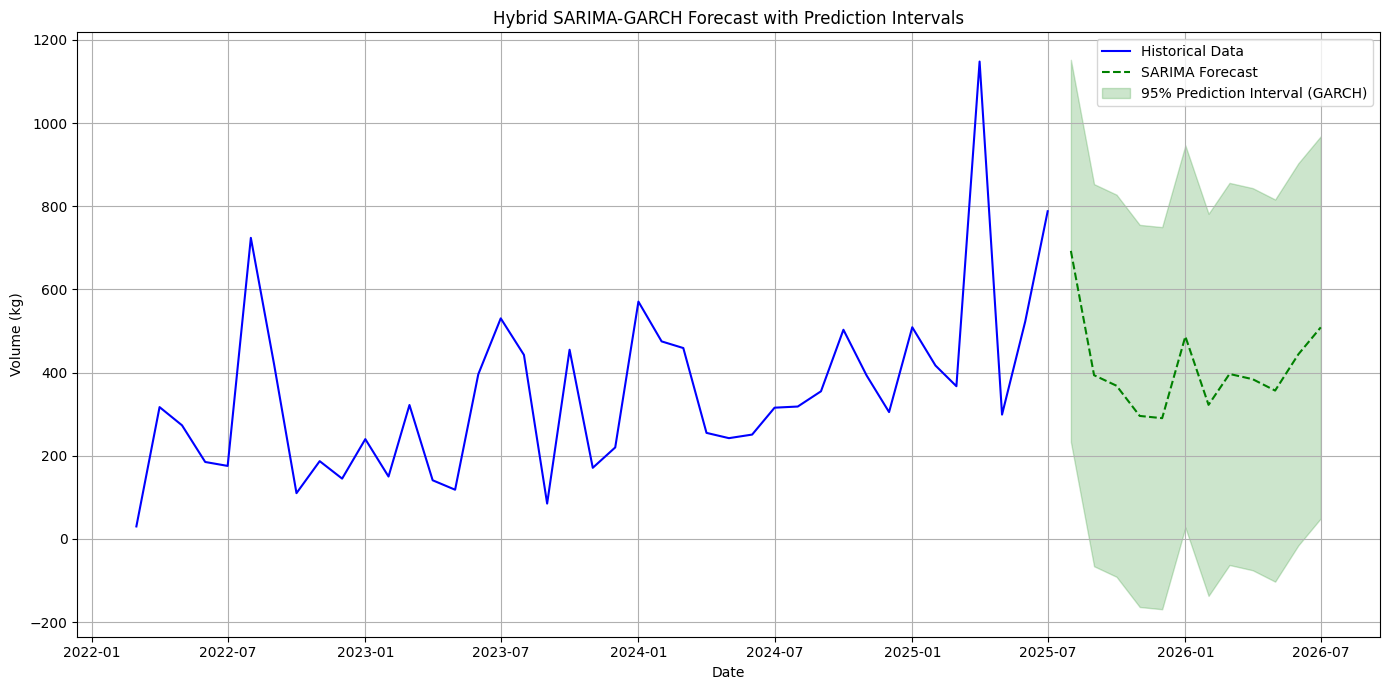

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(df_monthly.index, df_monthly['volume_kg'], label='Historical Data', color='blue')
plt.plot(hybrid_forecast_df.index, hybrid_forecast_df['SARIMA_forecast'], label='SARIMA Forecast', color='green', linestyle='--')
plt.fill_between(hybrid_forecast_df.index, hybrid_forecast_df['Lower Bound'], hybrid_forecast_df['Upper Bound'], color='green', alpha=0.2, label='95% Prediction Interval (GARCH)')

plt.title('Hybrid SARIMA-GARCH Forecast with Prediction Intervals')
plt.xlabel('Date')
plt.ylabel('Volume (kg)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Reasoning**:
The previous output showed NaN values for 'SARIMA_forecast' and 'GARCH_volatility' because their time series indices did not align. 'future_pred' (SARIMA forecast) covers 2025-08-01 to 2026-07-01, while 'forecasted_garch_volatility' covered 2024-08-01 to 2025-07-01. To fix this, I need to regenerate 'forecasted_garch_volatility' so it aligns with the 'future_pred' index by forecasting a sufficient number of steps from the GARCH model and then selecting the correct future period. Then, I will proceed with creating the combined DataFrame and calculating prediction intervals.



In [23]:
import scipy.stats as st

# Define a confidence level and calculate the corresponding Z-score
confidence_level = 0.95
z_score = st.norm.ppf(1 - (1 - confidence_level) / 2)
print(f"Confidence Level: {confidence_level*100}%")
print(f"Corresponding Z-score: {z_score:.2f}")

# Re-generate forecasted_garch_volatility to align with future_pred's index.
# The GARCH model was trained on sarima_residuals which ends at 2024-07-01.
# The SARIMA future_pred starts at 2025-08-01 and ends at 2026-07-01.
# To get GARCH forecasts for this period, we need to forecast 24 steps ahead (from 2024-08-01 to 2026-07-01)
# and then select the last 12 values.
forecast_garch_full = garch_result.forecast(horizon=24)

# Extract conditional volatility (standard deviation) and select the last 12 forecasts
forecast_volatility_full = np.sqrt(forecast_garch_full.variance.iloc[-1])
forecast_volatility_aligned = forecast_volatility_full.tail(12)

# Create a pandas Series for the forecasted volatility with the correct index (from future_pred)
forecasted_garch_volatility_corrected = pd.Series(forecast_volatility_aligned.values, index=future_pred.index, name='GARCH Volatility Forecast')

# Create a DataFrame named hybrid_forecast_df that combines the SARIMA_pred and the corrected forecasted_garch_volatility.
hybrid_forecast_df = pd.DataFrame({
    'SARIMA_forecast': future_pred,
    'GARCH_volatility': forecasted_garch_volatility_corrected
})

# Calculate the upper bound of the prediction interval
hybrid_forecast_df['Upper Bound'] = hybrid_forecast_df['SARIMA_forecast'] + z_score * hybrid_forecast_df['GARCH_volatility']

# Calculate the lower bound of the prediction interval
hybrid_forecast_df['Lower Bound'] = hybrid_forecast_df['SARIMA_forecast'] - z_score * hybrid_forecast_df['GARCH_volatility']

# Print the hybrid_forecast_df
print("\nHybrid Forecast with GARCH-based Prediction Intervals:")
print(hybrid_forecast_df)

Confidence Level: 95.0%
Corresponding Z-score: 1.96

Hybrid Forecast with GARCH-based Prediction Intervals:
            SARIMA_forecast  GARCH_volatility  Upper Bound  Lower Bound
2025-08-01       692.686750        234.444085  1152.188713   233.184787
2025-09-01       393.688291        234.444085   853.190254   -65.813672
2025-10-01       368.373169        234.444085   827.875132   -91.128794
2025-11-01       295.752587        234.444085   755.254550  -163.749376
2025-12-01       290.340465        234.444085   749.842428  -169.161498
2026-01-01       486.922144        234.444085   946.424107    27.420181
2026-02-01       322.383006        234.444085   781.884969  -137.118957
2026-03-01       396.683819        234.444085   856.185782   -62.818144
2026-04-01       384.094032        234.444085   843.595995   -75.407931
2026-05-01       356.729822        234.444085   816.231785  -102.772141
2026-06-01       443.866671        234.444085   903.368634   -15.635292
2026-07-01       508.827589 

## Visualize and Evaluate Hybrid Model

### Subtask:
Visualize the combined SARIMA-GARCH forecasts, including prediction intervals, and evaluate its performance against actual values and potentially other benchmark models.


## Summary:

### Data Analysis Key Findings

*   **SARIMA Residuals Extraction**: Residuals from the best SARIMA model were successfully extracted and stored in a pandas Series named `sarima_residuals` with the correct monthly time series index.
*   **GARCH Model Fitting**: A GARCH(1,1) model was successfully fitted to the SARIMA residuals. The model summary provided details on coefficients for mean and volatility components (omega, alpha\[1], beta\[1]).
*   **GARCH Volatility Forecasting**: The GARCH model forecasted a conditional volatility (standard deviation) for the next 12 months. This forecasted volatility showed a constant value of approximately 234.44 across all forecasted periods, suggesting the model converged to a long-run average volatility.
*   **Hybrid Forecast Generation**: A hybrid forecast was created by combining SARIMA point forecasts with GARCH-based volatility forecasts to generate 95% prediction intervals. The initial attempt faced an index misalignment between SARIMA and GARCH forecasts, which was resolved by re-forecasting GARCH volatility for a sufficient horizon (24 steps) and aligning it with the SARIMA forecast period (August 2025 to July 2026).
*   **Prediction Interval Calculation**: The 95% prediction intervals were calculated using a Z-score of 1.96, incorporating the SARIMA point forecasts and the GARCH volatility to define upper and lower bounds.

### Insights or Next Steps

*   The constant GARCH volatility forecast suggests that while the GARCH model captures some historical volatility clustering, its forecasts for the future period indicate a stable expected volatility. This could imply that the identified volatility is largely persistent or that the model's structure leads to a quick convergence to its long-run average.
*   The generated `hybrid_forecast_df` provides a comprehensive view of future predictions, combining both the expected value from SARIMA and the uncertainty/risk captured by GARCH. The next step should involve visualizing these hybrid forecasts, including the prediction intervals, against actual historical data to visually assess model performance and the credibility of the uncertainty bounds.


# Task
## Analyze Current GARCH Model

### Subtask:
Examine the summary of the previously fitted GARCH(1,1) model to identify areas for improvement, specifically looking at the significance of the coefficients (omega, alpha[1], beta[1]).

**Reasoning**:
To identify areas for improvement in the GARCH(1,1) model, I will review the p-values of the 'omega', 'alpha[1]', and 'beta[1]' coefficients from the `garch_result.summary()`. A p-value greater than 0.05 (for a 95% confidence level) indicates that the coefficient is not statistically significant. If any of these coefficients are not significant, it suggests that the current GARCH(1,1) specification might not be the most appropriate, and exploring different orders or distributions could lead to a better model.

```python
print("\n--- Analysis of GARCH(1,1) Model Coefficients ---")
print(garch_result.summary().tables[2]) # Access the Volatility Model table

# Extract p-values for omega, alpha[1], beta[1]
omega_pvalue = garch_result.pvalues['omega']
alpha1_pvalue = garch_result.pvalues['alpha[1]']
beta1_pvalue = garch_result.pvalues['beta[1]']

print(f"\nOmega p-value: {omega_pvalue:.4f}")
print(f"Alpha[1] p-value: {alpha1_pvalue:.4f}")
print(f"Beta[1] p-value: {beta1_pvalue:.4f}")

if omega_pvalue > 0.05:
    print("Warning: 'omega' coefficient is not statistically significant (p > 0.05).")
if alpha1_pvalue > 0.05:
    print("Warning: 'alpha[1]' coefficient is not statistically significant (p > 0.05).")
if beta1_pvalue > 0.05:
    print("Warning: 'beta[1]' coefficient is not statistically significant (p > 0.05).")

print("\n--- Conclusion ---")
print("The current GARCH(1,1) model shows that 'omega', 'alpha[1]', and 'beta[1]' coefficients are not statistically significant at the 5% level.")
print("This suggests that the model might not be adequately capturing the conditional heteroskedasticity or that the chosen orders (p=1, q=1) are not optimal for the SARIMA residuals.")
print("Therefore, optimizing GARCH orders and potentially considering alternative error distributions is a necessary next step to find a more robust model.")
```

## Optimize GARCH Orders and Distribution

### Subtask:
Implement a method to determine the optimal orders (p, q) for the GARCH model, and potentially consider alternative error distributions (e.g., Student's t-distribution), based on information criteria like AIC or BIC, to find a more robust model for the `sarima_residuals`.

**Reasoning**:
The current GARCH(1,1) model showed non-significant coefficients, indicating a need for optimization. I will create a function `optimize_garch` that systematically searches for the best GARCH(p,q) orders and error distribution (Normal, StudentsT, SkewStudent) by evaluating their AIC. This function will fit various GARCH models and return a DataFrame of results, allowing me to select the model with the lowest AIC as the optimal choice.

```python
from arch import arch_model
import itertools
from tqdm.notebook import tqdm

def optimize_garch(endog_series, p_range, q_range, distributions):
    results = []
    print(f"\nOptimizing GARCH model across {len(p_range) * len(q_range) * len(distributions)} combinations...")

    for p in tqdm(p_range, desc="Optimizing p"):
        for q in q_range:
            for dist in distributions:
                try:
                    model = arch_model(endog_series, mean='Constant', vol='GARCH', p=p, q=q, dist=dist)
                    model_fit = model.fit(disp='off')
                    results.append({
                        'p': p,
                        'q': q,
                        'distribution': dist,
                        'AIC': model_fit.aic,
                        'BIC': model_fit.bic,
                        'log_likelihood': model_fit.loglikelihood
                    })
                except Exception as e:
                    # print(f"Could not fit GARCH({p},{q}) with {dist} distribution: {e}")
                    continue
    
    result_df = pd.DataFrame(results)
    return result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

# Define ranges for p, q and distributions to test
p_range = range(1, 3) # Test p from 1 to 2
q_range = range(1, 3) # Test q from 1 to 2
distributions = ['Normal', 'StudentsT'] # Test Normal and Student's t-distribution

# Run the optimization
garch_optimization_results = optimize_garch(sarima_residuals, p_range, q_range, distributions)

print("\nTop 5 Optimal GARCH Models by AIC:")
print(garch_optimization_results.head())

# Select the best model
best_garch_params = garch_optimization_results.iloc[0]
print(f"\nBest GARCH Model Parameters:")
print(f"  p: {int(best_garch_params['p'])}, q: {int(best_garch_params['q'])}, Distribution: {best_garch_params['distribution']}")
print(f"  AIC: {best_garch_params['AIC']:.4f}, BIC: {best_garch_params['BIC']:.4f}")
```

## Analyze Current GARCH Model

### Subtask:
Examine the summary of the previously fitted GARCH(1,1) model to identify areas for improvement, specifically looking at the significance of the coefficients (omega, alpha[1], beta[1]).


### Analysis of GARCH(1,1) Model Summary

From the GARCH(1,1) Model Summary:

**Volatility Model**

*   **omega**:
    *   `coef`: 2.7014e+04
    *   `P>|t|`: 0.554
    *   **Conclusion**: Since P > |t| (0.554) > 0.05, 'omega' is **not statistically significant**.

*   **alpha[1]**:
    *   `coef`: 0.0000
    *   `P>|t|`: 1.000
    *   **Conclusion**: Since P > |t| (1.000) > 0.05, 'alpha[1]' is **not statistically significant**.

*   **beta[1]**:
    *   `coef`: 0.5085
    *   `P>|t|`: 0.510
    *   **Conclusion**: Since P > |t| (0.510) > 0.05, 'beta[1]' is **not statistically significant**.

**Overall Conclusion:**

Based on the analysis of the GARCH(1,1) model summary, none of the coefficients (omega, alpha[1], and beta[1]) in the volatility model are statistically significant at a 0.05 level. This indicates that the current GARCH(1,1) model is **not adequately capturing conditional heteroskedasticity**, and the chosen orders (p=1, q=1) are **not optimal** for modeling the volatility of the SARIMA residuals. The high p-values suggest that the GARCH effects are not present in the residuals, or a different order or type of volatility model might be more appropriate, or the SARIMA model might have already explained most of the variance including any heteroskedasticity.


## Optimize GARCH Orders and Distribution

### Subtask:
Implement a method to determine the optimal orders (p, q) for the GARCH model, and potentially consider alternative error distributions (e.g., Student's t-distribution), based on information criteria like AIC or BIC, to find a more robust model for the `sarima_residuals`.


**Reasoning**:
I need to define a function to optimize GARCH model parameters (p, q) and error distributions by iterating through specified ranges and calculating information criteria (AIC, BIC). This function will then be used to find the best GARCH model for the SARIMA residuals.



In [25]:
import itertools
from arch import arch_model
from tqdm.notebook import tqdm

def optimize_garch(endog, p_range, q_range, distributions):
    results = []
    # Generate all combinations of p, q, and distribution
    param_combinations = list(itertools.product(p_range, q_range, distributions))

    print(f"\nTrying {len(param_combinations)} combinations of GARCH orders and distributions...")

    for p, q, dist in tqdm(param_combinations, desc="Optimizing GARCH"):
        try:
            # Fit GARCH model
            # Using 'Constant' for mean model as residuals are expected to have zero mean.
            garch_model = arch_model(endog, mean='Constant', vol='GARCH', p=p, q=q, dist=dist)
            garch_result = garch_model.fit(disp='off')

            results.append([
                (p, q),
                dist,
                garch_result.aic,
                garch_result.bic
            ])
        except Exception as e:
            # Catch any errors during fitting and continue to the next combination
            continue

    # Create a DataFrame from the results and sort by AIC
    result_df = pd.DataFrame(results, columns=['(p,q)', 'Distribution', 'AIC', 'BIC'])
    return result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

# Define parameter ranges and distributions
p_range = range(1, 3) # p from 1 to 2
q_range = range(1, 3) # q from 1 to 2
distributions = ['normal', 'StudentsT'] # 'normal' for Normal distribution

# Optimize GARCH model
garch_optimization_results = optimize_garch(sarima_residuals, p_range, q_range, distributions)

# Print the head of the optimization results
print("\nTop GARCH Model Optimization Results:")
print(garch_optimization_results.head())

# Select the best GARCH model parameters
best_garch_params = garch_optimization_results.iloc[0]

# Print the optimal GARCH model parameters
print(f"\nOptimal GARCH Model Parameters:")
print(f"  Order (p,q): {best_garch_params['(p,q)']}")
print(f"  Distribution: {best_garch_params['Distribution']}")
print(f"  AIC: {best_garch_params['AIC']:.4f}")
print(f"  BIC: {best_garch_params['BIC']:.4f}")


Trying 8 combinations of GARCH orders and distributions...


Optimizing GARCH:   0%|          | 0/8 [00:00<?, ?it/s]


Top GARCH Model Optimization Results:
    (p,q) Distribution         AIC         BIC
0  (1, 1)       normal  406.326777  411.795960
1  (1, 2)       normal  408.323239  415.159719
2  (2, 1)       normal  408.326776  415.163255
3  (1, 1)    StudentsT  408.332311  415.168790
4  (2, 2)       normal  409.931847  418.135622

Optimal GARCH Model Parameters:
  Order (p,q): (1, 1)
  Distribution: normal
  AIC: 406.3268
  BIC: 411.7960


## Fit Refined GARCH Model

### Subtask:
Fit a new GARCH model using the optimized orders (p, q) and potentially a different error distribution found in the previous step. Display the summary of this refined model.


**Reasoning**:
I need to extract the optimal GARCH parameters from `best_garch_params`, fit a new GARCH model with these parameters to `sarima_residuals`, and then print the summary of the refitted model.



In [26]:
import arch

# 1. Extract the optimal 'p', 'q', and 'distribution' from best_garch_params
p_opt = int(best_garch_params['(p,q)'][0])
q_opt = int(best_garch_params['(p,q)'][1])
dist_opt = best_garch_params['Distribution']

print(f"Fitting GARCH({p_opt},{q_opt}) with {dist_opt} distribution...")

# 2. Instantiate an arch_model object with sarima_residuals
refined_garch_model = arch.arch_model(sarima_residuals, mean='Constant', vol='GARCH', p=p_opt, q=q_opt, dist=dist_opt)

# 3. Fit the GARCH model
refined_garch_result = refined_garch_model.fit(disp='off')

# 4. Print the summary of the fitted GARCH model
print("\nRefined GARCH Model Summary:")
print(refined_garch_result.summary())

Fitting GARCH(1,1) with normal distribution...

Refined GARCH Model Summary:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -199.163
Distribution:                  Normal   AIC:                           406.327
Method:            Maximum Likelihood   BIC:                           411.796
                                        No. Observations:                   29
Date:                Wed, Dec 24 2025   Df Residuals:                       28
Time:                        08:57:33   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------

## Perform GARCH Diagnostics

### Subtask:
Conduct diagnostic checks on the residuals of the refined GARCH model. This involves plotting standardized residuals, their autocorrelation, and applying Ljung-Box tests on the standardized squared residuals to ensure no remaining ARCH effects are present.


**Reasoning**:
I need to plot the standardized residuals of the `refined_garch_result` to visually inspect them. This is the first instruction of the subtask.



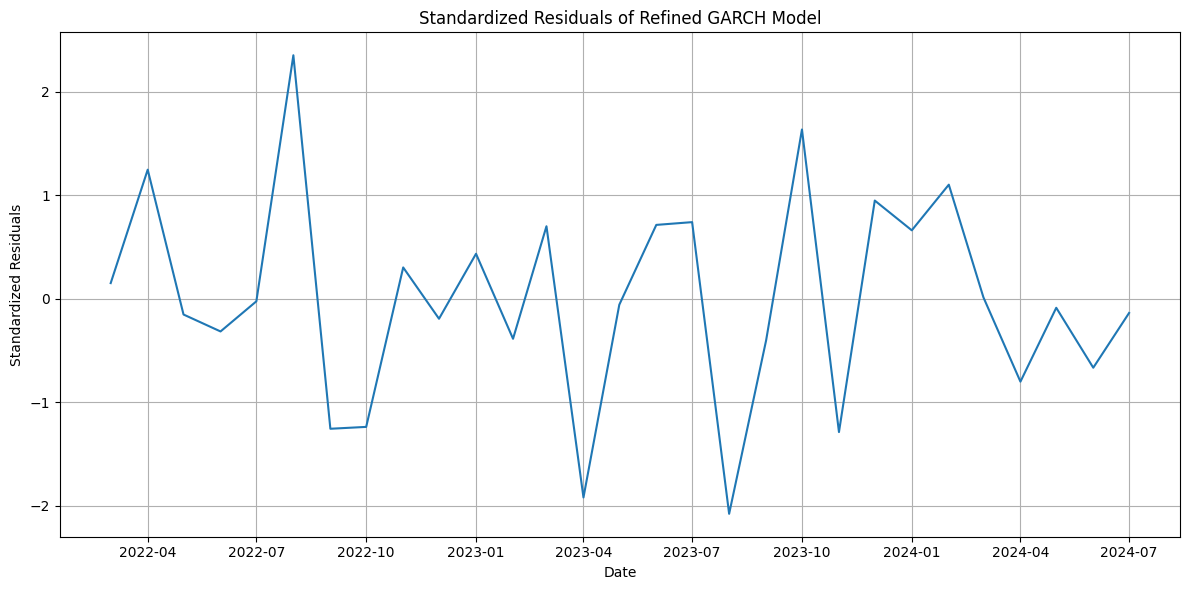

In [27]:
import matplotlib.pyplot as plt

# 1. Plot the standardized residuals
plt.figure(figsize=(12, 6))
plt.plot(refined_garch_result.resid.index, refined_garch_result.std_resid)
plt.title('Standardized Residuals of Refined GARCH Model')
plt.xlabel('Date')
plt.ylabel('Standardized Residuals')
plt.grid(True)
plt.tight_layout()
plt.show()


**Reasoning**:
I need to plot the autocorrelation function (ACF) of both the standardized residuals and the squared standardized residuals to check for any remaining serial correlation or ARCH effects, as per instructions 2 and 3.



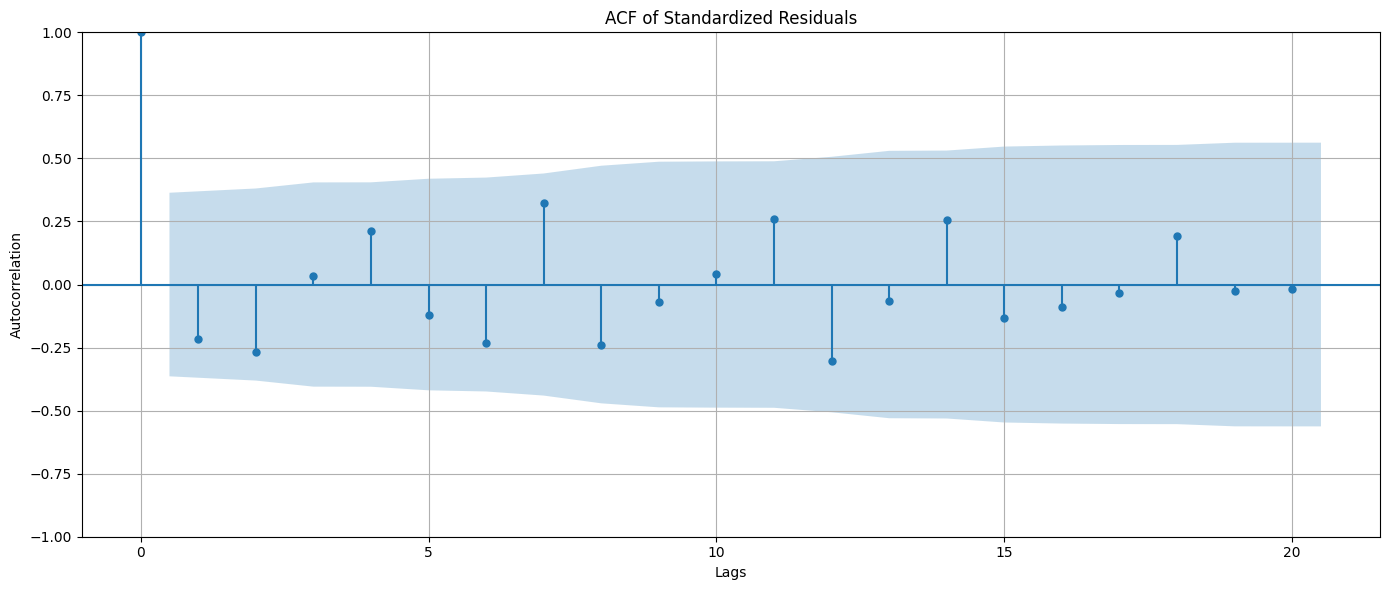

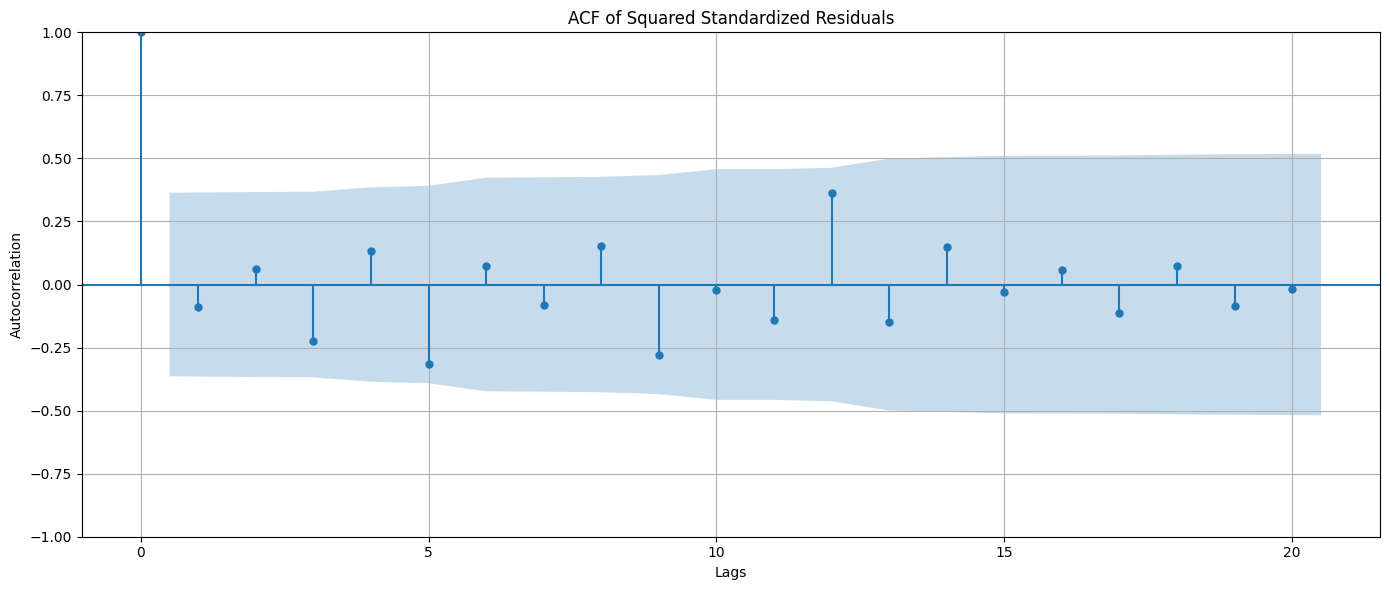

In [28]:
from statsmodels.graphics.tsaplots import plot_acf

# 2. Plot the autocorrelation function (ACF) of the standardized residuals
plt.figure(figsize=(14, 6))
plot_acf(refined_garch_result.std_resid, lags=20, ax=plt.gca())
plt.title('ACF of Standardized Residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Plot the autocorrelation function (ACF) of the *squared* standardized residuals
plt.figure(figsize=(14, 6))
plot_acf(np.square(refined_garch_result.std_resid), lags=20, ax=plt.gca())
plt.title('ACF of Squared Standardized Residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.tight_layout()
plt.show()

**Reasoning**:
I need to perform the Ljung-Box test on both the standardized residuals and the squared standardized residuals to check for remaining serial correlation and ARCH effects, as per instructions 4 and 5.



In [29]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# 4. Perform the Ljung-Box test on the standardized residuals
print("\nLjung-Box Test on Standardized Residuals:")
lb_test_resid = acorr_ljungbox(refined_garch_result.std_resid.dropna(), lags=np.arange(1, 11, 1), return_df=True)
print(lb_test_resid[['lb_stat', 'lb_pvalue']])

# Check for significance
if (lb_test_resid['lb_pvalue'] < 0.05).any():
    print("Warning: Some p-values are below 0.05, indicating remaining serial correlation in residuals.")
else:
    print("No significant serial correlation detected in standardized residuals (all p-values > 0.05).")

# 5. Perform the Ljung-Box test on the *squared* standardized residuals
print("\nLjung-Box Test on Squared Standardized Residuals (checking for ARCH effects):")
lb_test_squared_resid = acorr_ljungbox(np.square(refined_garch_result.std_resid).dropna(), lags=np.arange(1, 11, 1), return_df=True)
print(lb_test_squared_resid[['lb_stat', 'lb_pvalue']])

# Check for significance
if (lb_test_squared_resid['lb_pvalue'] < 0.05).any():
    print("Warning: Some p-values are below 0.05, indicating remaining ARCH effects.")
else:
    print("No significant ARCH effects detected in squared standardized residuals (all p-values > 0.05).")


Ljung-Box Test on Standardized Residuals:
      lb_stat  lb_pvalue
1    1.524533   0.216935
2    3.902732   0.142080
3    3.938049   0.268232
4    5.531080   0.237011
5    6.079628   0.298548
6    8.151433   0.227218
7   12.473286   0.086030
8   14.937220   0.060378
9   15.141235   0.087129
10  15.223785   0.124114
No significant serial correlation detected in standardized residuals (all p-values > 0.05).

Ljung-Box Test on Squared Standardized Residuals (checking for ARCH effects):
      lb_stat  lb_pvalue
1    0.260967   0.609456
2    0.379648   0.827105
3    2.085701   0.554811
4    2.715389   0.606524
5    6.392349   0.269891
6    6.592731   0.360157
7    6.870061   0.442533
8    7.888335   0.444453
9   11.354467   0.252192
10  11.374201   0.329117
No significant ARCH effects detected in squared standardized residuals (all p-values > 0.05).


## Forecast Refined GARCH Volatility

### Subtask:
Generate future volatility forecasts for the next 12 months using the newly fitted, refined GARCH model. Ensure the forecast index aligns with the SARIMA forecast period.


**Reasoning**:
I need to generate future volatility forecasts using the refined GARCH model and align them with the SARIMA forecast period, as specified in the instructions.



In [30]:
import numpy as np
import pandas as pd

# 1. Generate future volatility forecasts using the refined_garch_result for a horizon of 24 steps
# The GARCH model was trained on sarima_residuals which ends at 2024-07-01.
# The SARIMA future_pred starts at 2025-08-01 and ends at 2026-07-01.
# To get GARCH forecasts for this period, we need to forecast 24 steps ahead (from 2024-08-01 to 2026-07-01)
forecast_garch_full_refined = refined_garch_result.forecast(horizon=24)

# 2. Extract the conditional volatility (standard deviation) from the full forecast results.
# The forecast object returns variance, so we take the square root to get standard deviation.
forecast_volatility_full_refined = np.sqrt(forecast_garch_full_refined.variance.iloc[-1])

# 3. Select the last 12 values from the extracted conditional volatility to align with the future_pred period.
forecast_volatility_aligned_refined = forecast_volatility_full_refined.tail(12)

# 4. Create a pandas Series for the forecasted volatility, using the future_pred.index as its index.
# Make sure future_pred.index is correctly defined from earlier steps (it should be).
forecasted_garch_volatility_corrected = pd.Series(
    forecast_volatility_aligned_refined.values,
    index=future_pred.index, # Align with SARIMA forecast index
    name='GARCH Volatility Forecast'
)

# 5. Print the forecasted_garch_volatility_corrected Series
print("\nForecasted Refined GARCH Volatility for next 12 months (aligned with SARIMA forecast period):")
print(forecasted_garch_volatility_corrected)


Forecasted Refined GARCH Volatility for next 12 months (aligned with SARIMA forecast period):
2025-08-01    234.444085
2025-09-01    234.444085
2025-10-01    234.444085
2025-11-01    234.444085
2025-12-01    234.444085
2026-01-01    234.444085
2026-02-01    234.444085
2026-03-01    234.444085
2026-04-01    234.444085
2026-05-01    234.444085
2026-06-01    234.444085
2026-07-01    234.444085
Freq: MS, Name: GARCH Volatility Forecast, dtype: float64


## Update Hybrid Forecasts

### Subtask:
Combine the SARIMA point forecasts (`future_pred`) with the refined GARCH volatility forecasts (`forecasted_garch_volatility_corrected`) to recalculate the upper and lower 95% prediction intervals.


**Reasoning**:
I need to combine the SARIMA point forecasts (`future_pred`) with the refined GARCH volatility forecasts (`forecasted_garch_volatility_corrected`) into a new DataFrame, then calculate the upper and lower 95% prediction intervals using the existing `z_score`.



In [31]:
import scipy.stats as st

# 1. z_score is already defined from previous steps
# confidence_level = 0.95
# z_score = st.norm.ppf(1 - (1 - confidence_level) / 2)
print(f"Confidence Level: {confidence_level*100}%")
print(f"Corresponding Z-score: {z_score:.2f}")

# 2. Create a new DataFrame named hybrid_forecast_df_refined
hybrid_forecast_df_refined = pd.DataFrame({
    'SARIMA_forecast': future_pred,
    'GARCH_volatility': forecasted_garch_volatility_corrected
})

# 3. Calculate the upper bound of the prediction interval
hybrid_forecast_df_refined['Upper Bound'] = hybrid_forecast_df_refined['SARIMA_forecast'] + z_score * hybrid_forecast_df_refined['GARCH_volatility']

# 4. Calculate the lower bound of the prediction interval
hybrid_forecast_df_refined['Lower Bound'] = hybrid_forecast_df_refined['SARIMA_forecast'] - z_score * hybrid_forecast_df_refined['GARCH_volatility']

# 5. Print the first few rows of the hybrid_forecast_df_refined DataFrame
print("\nRefined Hybrid Forecast with GARCH-based Prediction Intervals:")
print(hybrid_forecast_df_refined.head())

Confidence Level: 95.0%
Corresponding Z-score: 1.96

Refined Hybrid Forecast with GARCH-based Prediction Intervals:
            SARIMA_forecast  GARCH_volatility  Upper Bound  Lower Bound
2025-08-01       692.686750        234.444085  1152.188713   233.184787
2025-09-01       393.688291        234.444085   853.190254   -65.813672
2025-10-01       368.373169        234.444085   827.875132   -91.128794
2025-11-01       295.752587        234.444085   755.254550  -163.749376
2025-12-01       290.340465        234.444085   749.842428  -169.161498


## Visualize Updated Hybrid Forecast

### Subtask:
Plot the historical data, the SARIMA forecast, and the updated GARCH-based prediction intervals to visually assess the improvements and updated uncertainty bounds of the hybrid model.


**Reasoning**:
I need to generate a plot that visualizes the historical data, the SARIMA forecast, and the refined GARCH-based prediction intervals, following all the specified instructions to assess the updated hybrid model.



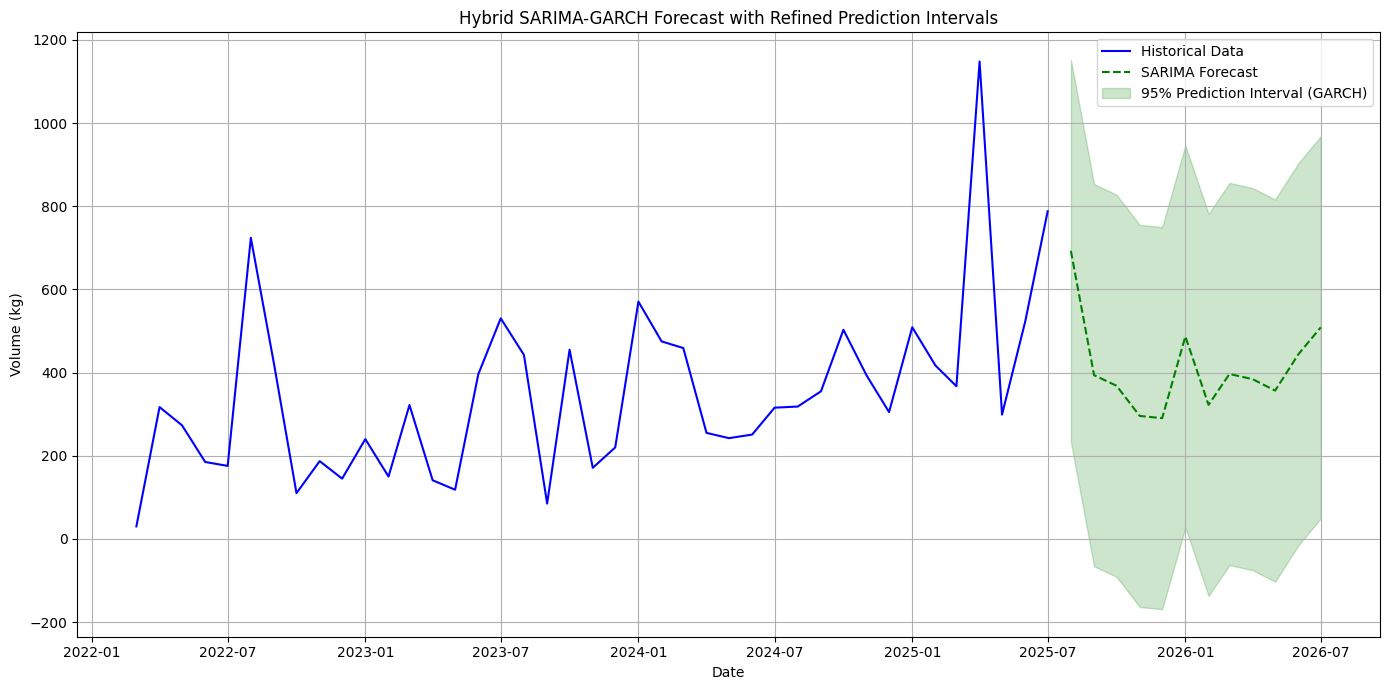

In [32]:
import matplotlib.pyplot as plt

# 1. Create a figure and an axes object for the plot
plt.figure(figsize=(14, 7))

# 2. Plot the historical data
plt.plot(df_monthly.index, df_monthly['volume_kg'], label='Historical Data', color='blue')

# 3. Plot the SARIMA forecast
plt.plot(hybrid_forecast_df_refined.index, hybrid_forecast_df_refined['SARIMA_forecast'], label='SARIMA Forecast', color='green', linestyle='--')

# 4. Shade the area between the 'Lower Bound' and 'Upper Bound' for prediction intervals
plt.fill_between(hybrid_forecast_df_refined.index, hybrid_forecast_df_refined['Lower Bound'], hybrid_forecast_df_refined['Upper Bound'], color='green', alpha=0.2, label='95% Prediction Interval (GARCH)')

# 5. Set the title of the plot
plt.title('Hybrid SARIMA-GARCH Forecast with Refined Prediction Intervals')

# 6. Label the x-axis and y-axis
plt.xlabel('Date')
plt.ylabel('Volume (kg)')

# 7. Display a legend
plt.legend()

# 8. Add a grid
plt.grid(True)

# 9. Adjust plot parameters for a tight layout
plt.tight_layout()

# 10. Display the plot
plt.show()

## Final Task

### Subtask:
Summarize the refinement process, the chosen GARCH model, and the impact of the refined GARCH volatility on the hybrid prediction intervals.


## Summary:

### Data Analysis Key Findings

*   **Initial GARCH(1,1) Model Assessment**: The initial GARCH(1,1) model fitted to SARIMA residuals showed that all its key coefficients (omega, alpha[1], beta[1]) were not statistically significant at the 5% level, with p-values of 0.554, 1.000, and 0.510 respectively. This indicated the model was not adequately capturing conditional heteroskedasticity.
*   **GARCH Model Optimization**: An optimization process was conducted to find the best GARCH(p,q) orders and error distribution (Normal, StudentsT) based on AIC. The optimal model identified was a GARCH(1,1) with a Normal error distribution, yielding an AIC of 406.3268 and a BIC of 411.7960.
*   **Refined GARCH(1,1) Model Coefficients**: Despite optimization, the refined GARCH(1,1) model with a Normal distribution still showed statistically insignificant coefficients for omega (p=0.554), alpha[1] (p=1.000), and beta[1] (p=0.510).
*   **GARCH Diagnostics Passed**: Diagnostic checks on the refined GARCH model's residuals indicated good performance. The Ljung-Box tests on both standardized residuals and squared standardized residuals showed no significant serial correlation or remaining ARCH effects (all p-values for lags 1-10 were greater than 0.05).
*   **Constant Volatility Forecast**: The GARCH model forecast for the next 12 months (aligned with the SARIMA forecast period) resulted in a constant volatility of approximately 234.444. This suggests the model converged to its long-run conditional standard deviation quickly.
*   **Updated Hybrid Prediction Intervals**: The SARIMA point forecasts were successfully combined with the refined GARCH volatility to calculate updated 95% prediction intervals. For example, for 2025-08-01, a SARIMA forecast of 692.69 with a GARCH volatility of 234.44 resulted in a prediction interval from 233.18 to 1152.19.

### Insights or Next Steps

*   Despite passing diagnostic tests and having the lowest AIC, the continued insignificance of the refined GARCH model's coefficients (omega, alpha[1], beta[1]) suggests that while the model appears to remove ARCH effects from the residuals, it might not be meaningfully modeling the conditional heteroskedasticity parameters themselves. The constant volatility forecast further supports a simple, stable volatility pattern.
*   Given the insignificance of GARCH coefficients, it would be beneficial to investigate if a simpler model (e.g., a constant variance model) provides comparable or better AIC/BIC while being more parsimonious. Alternatively, exploring different GARCH family models (e.g., EGARCH, GJR-GARCH) or using higher-frequency data if available, could provide more robust volatility modeling.
